## Q1

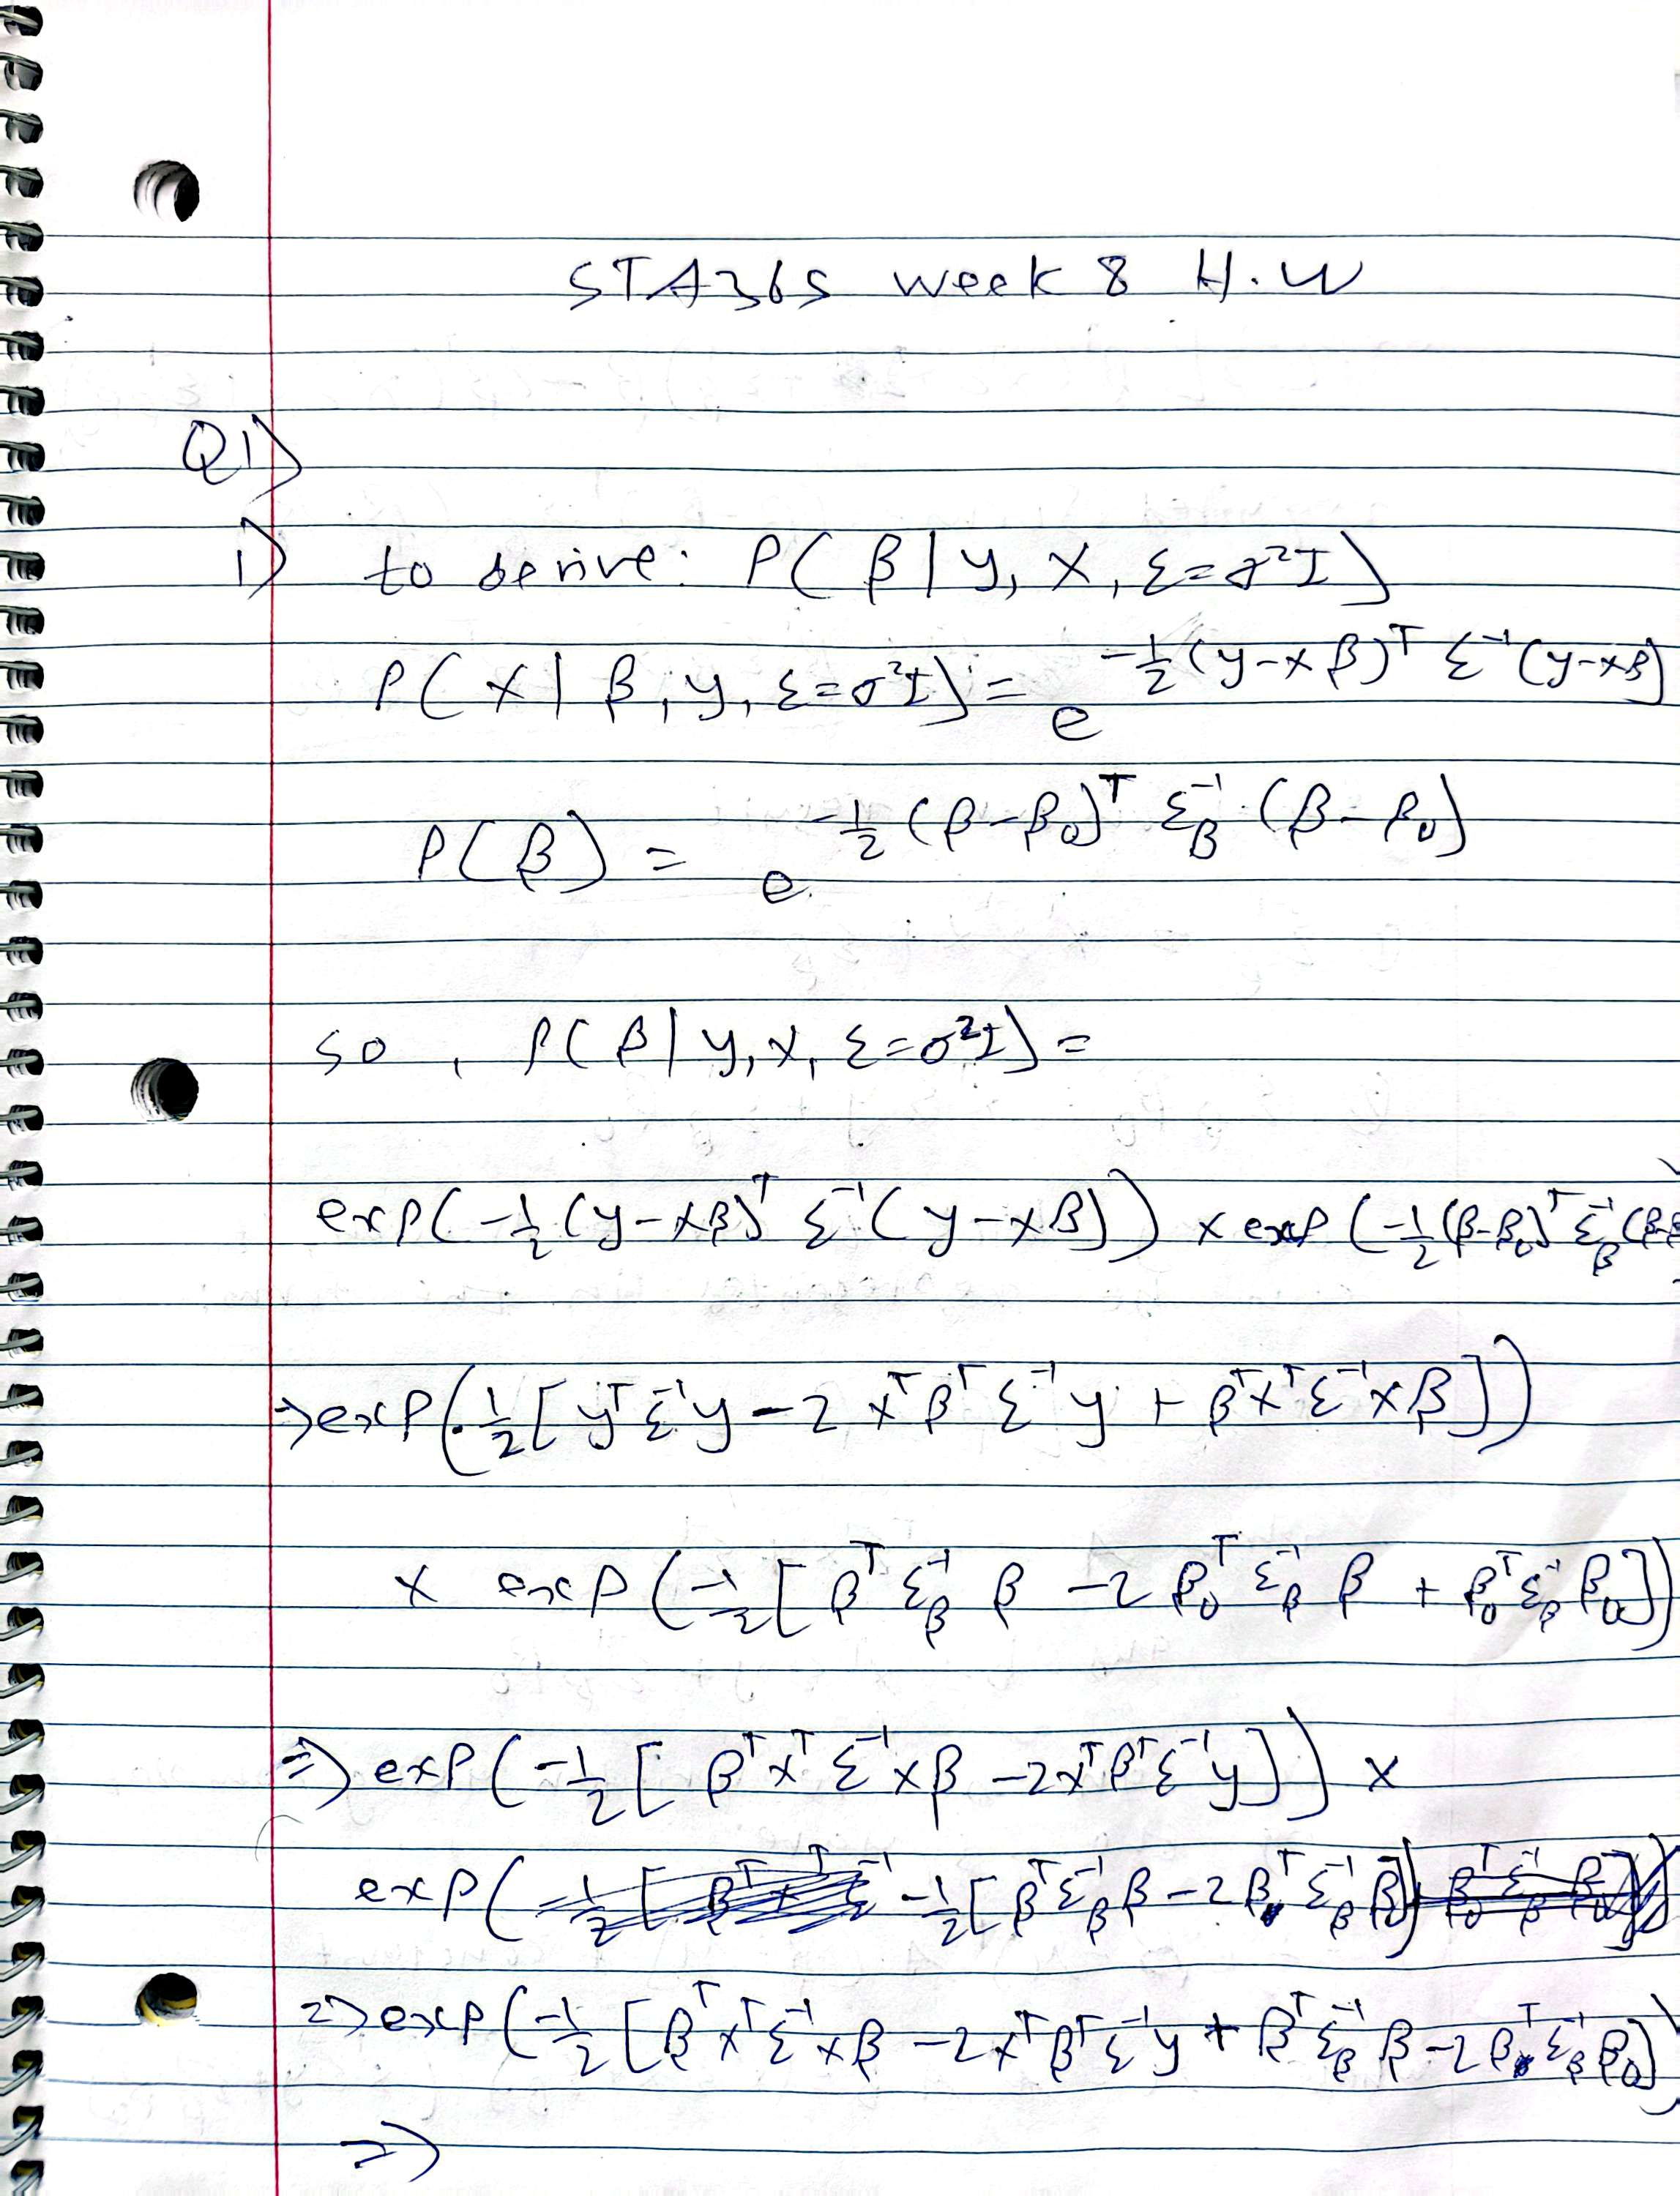

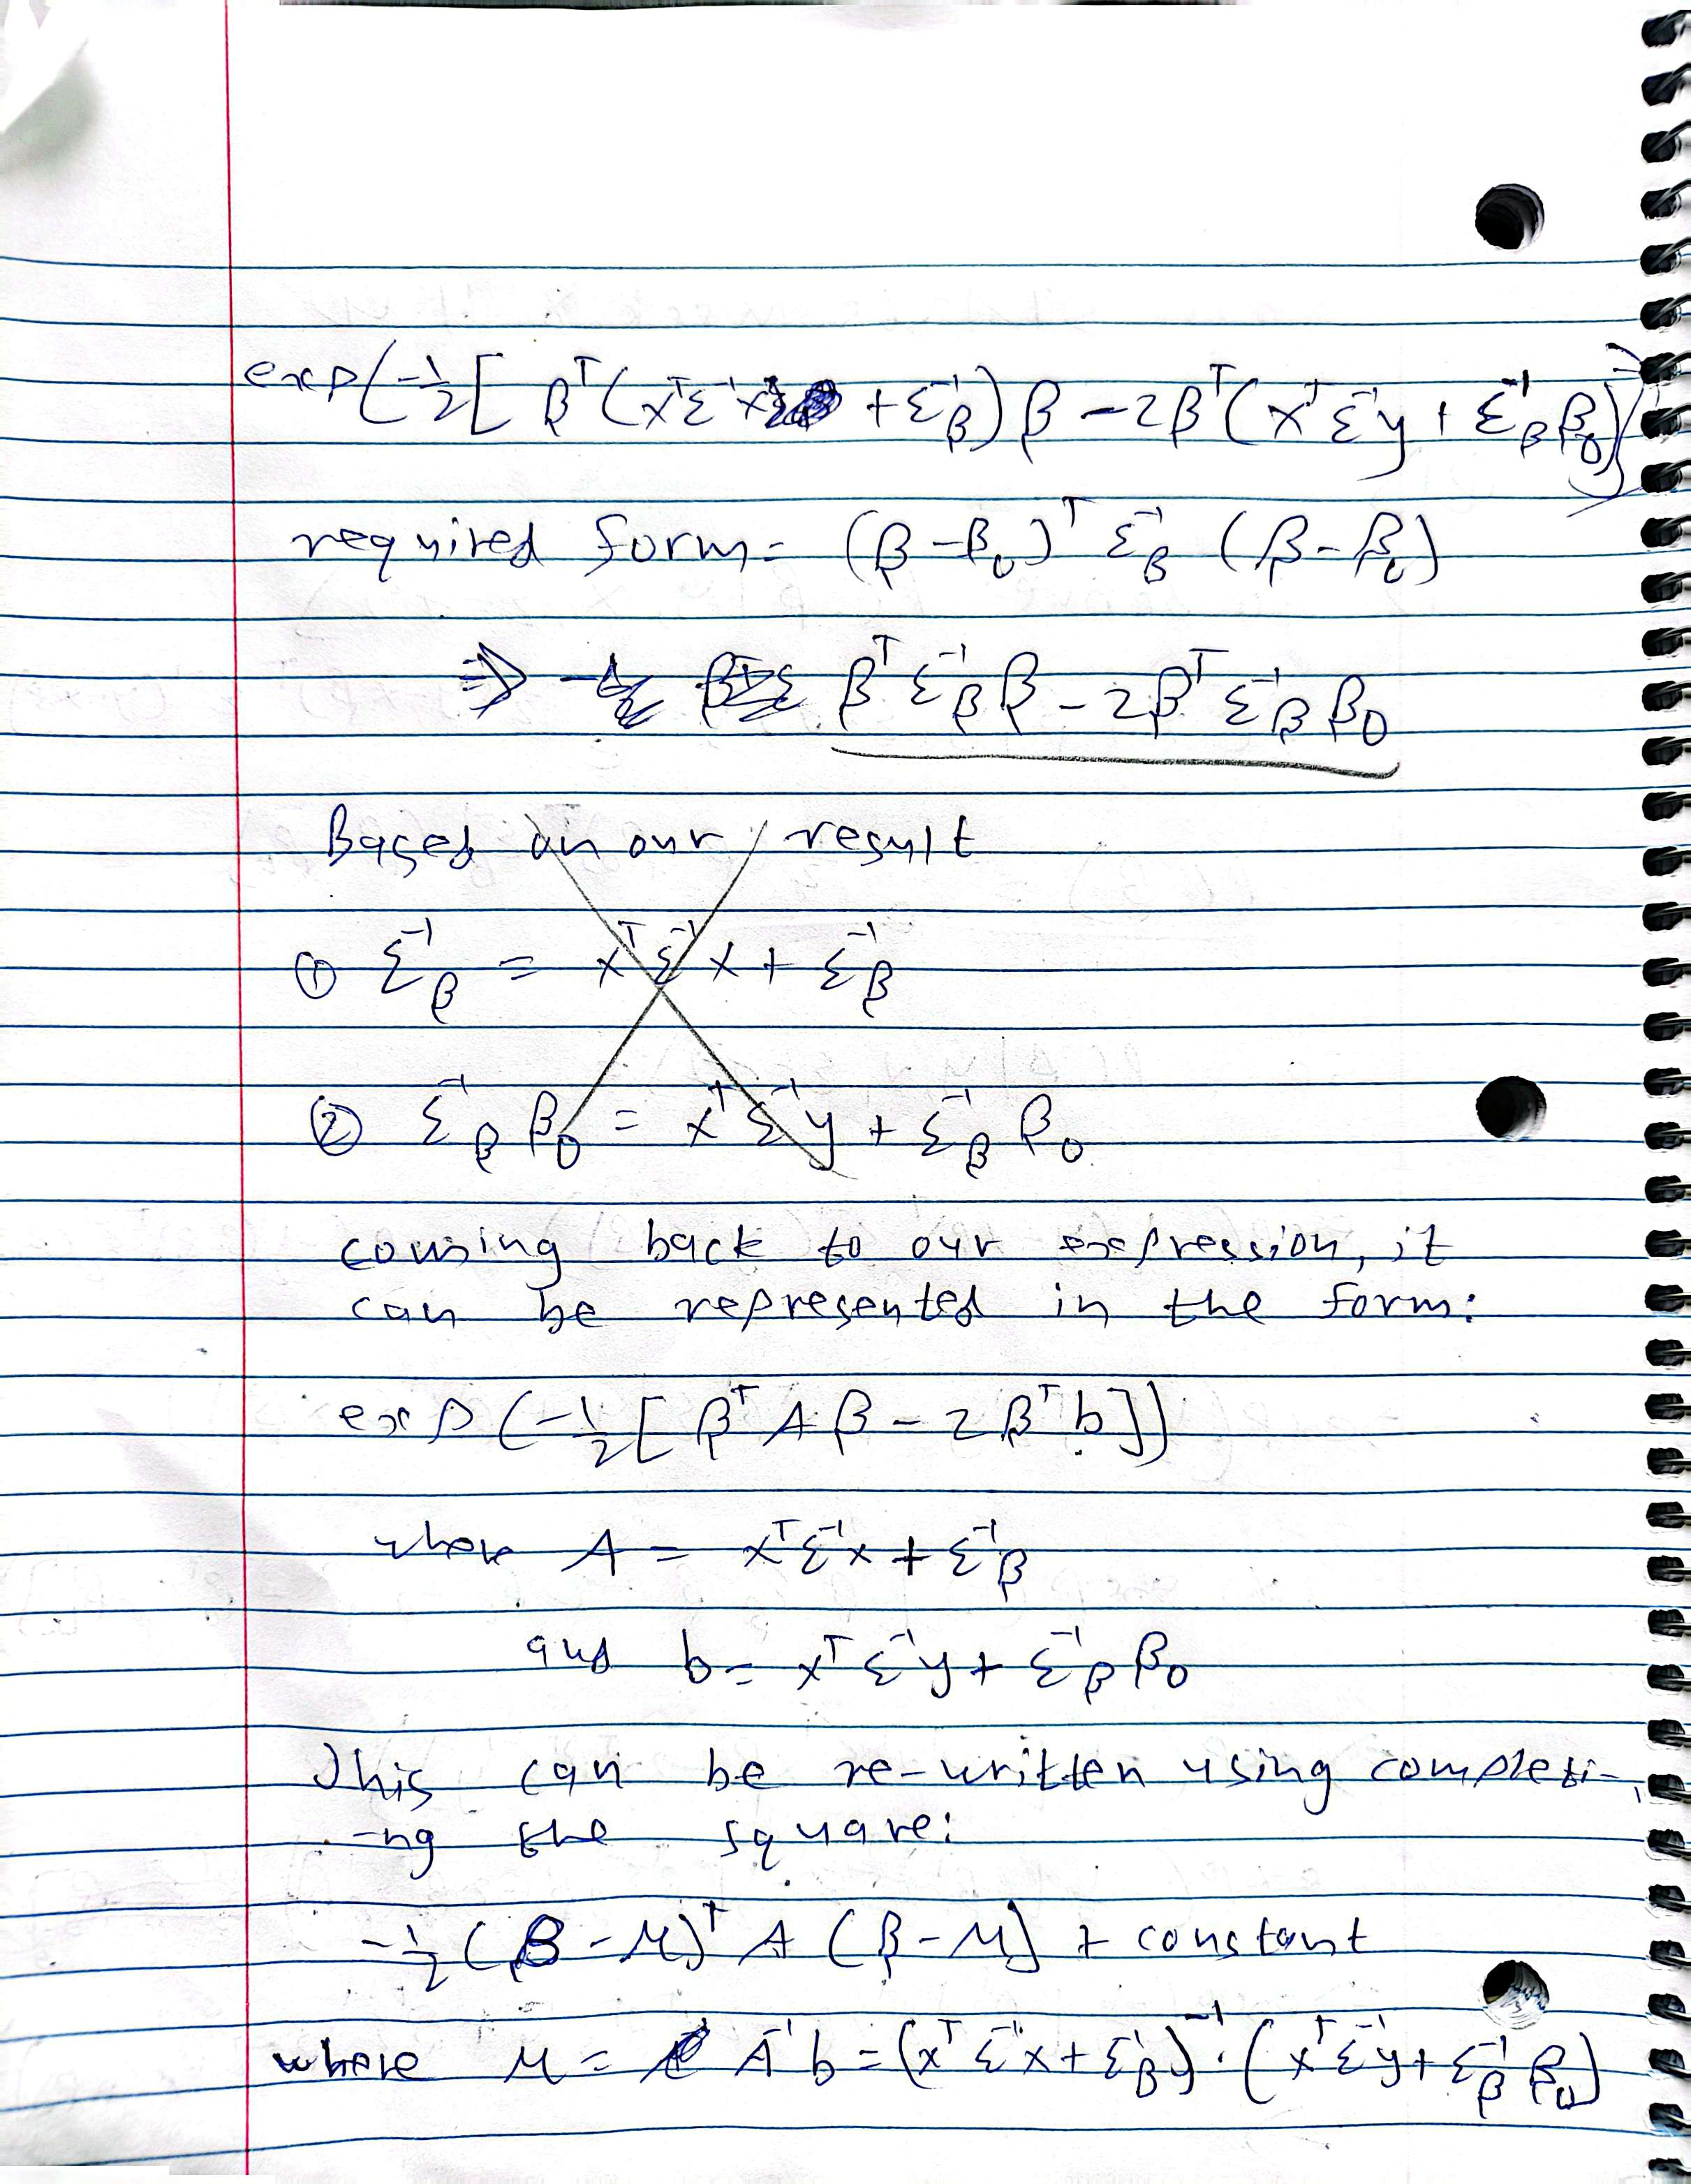

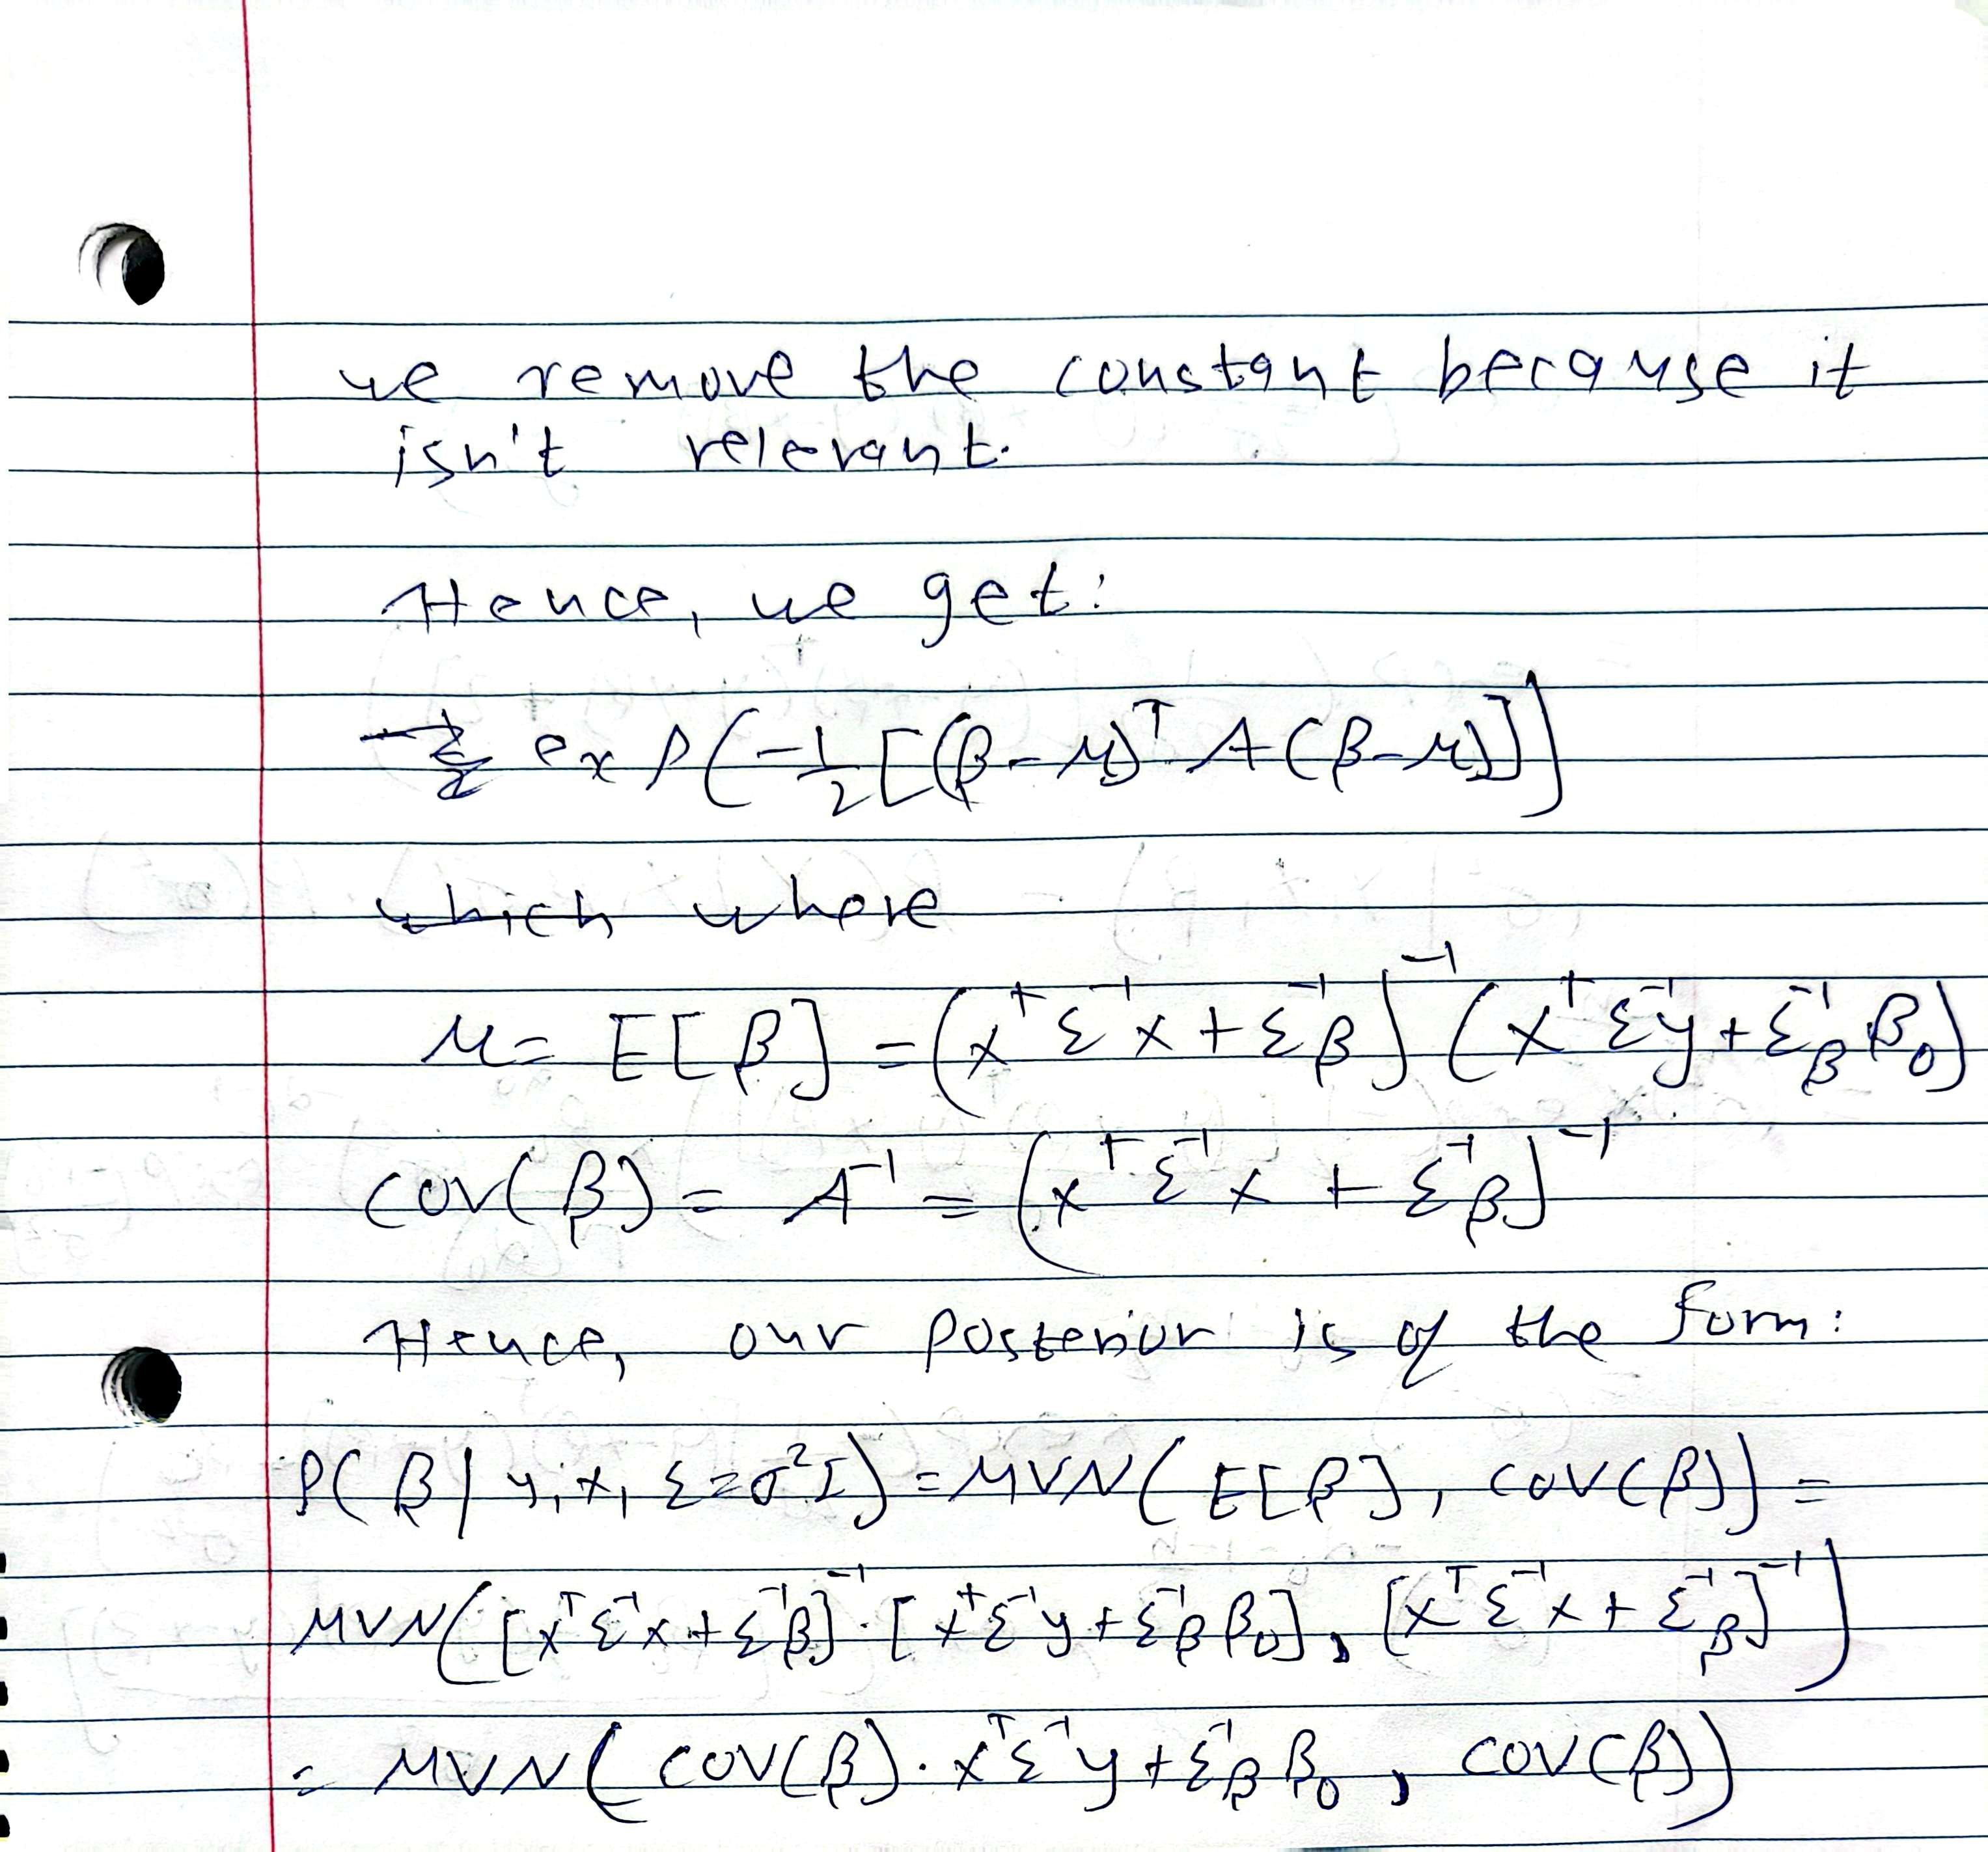

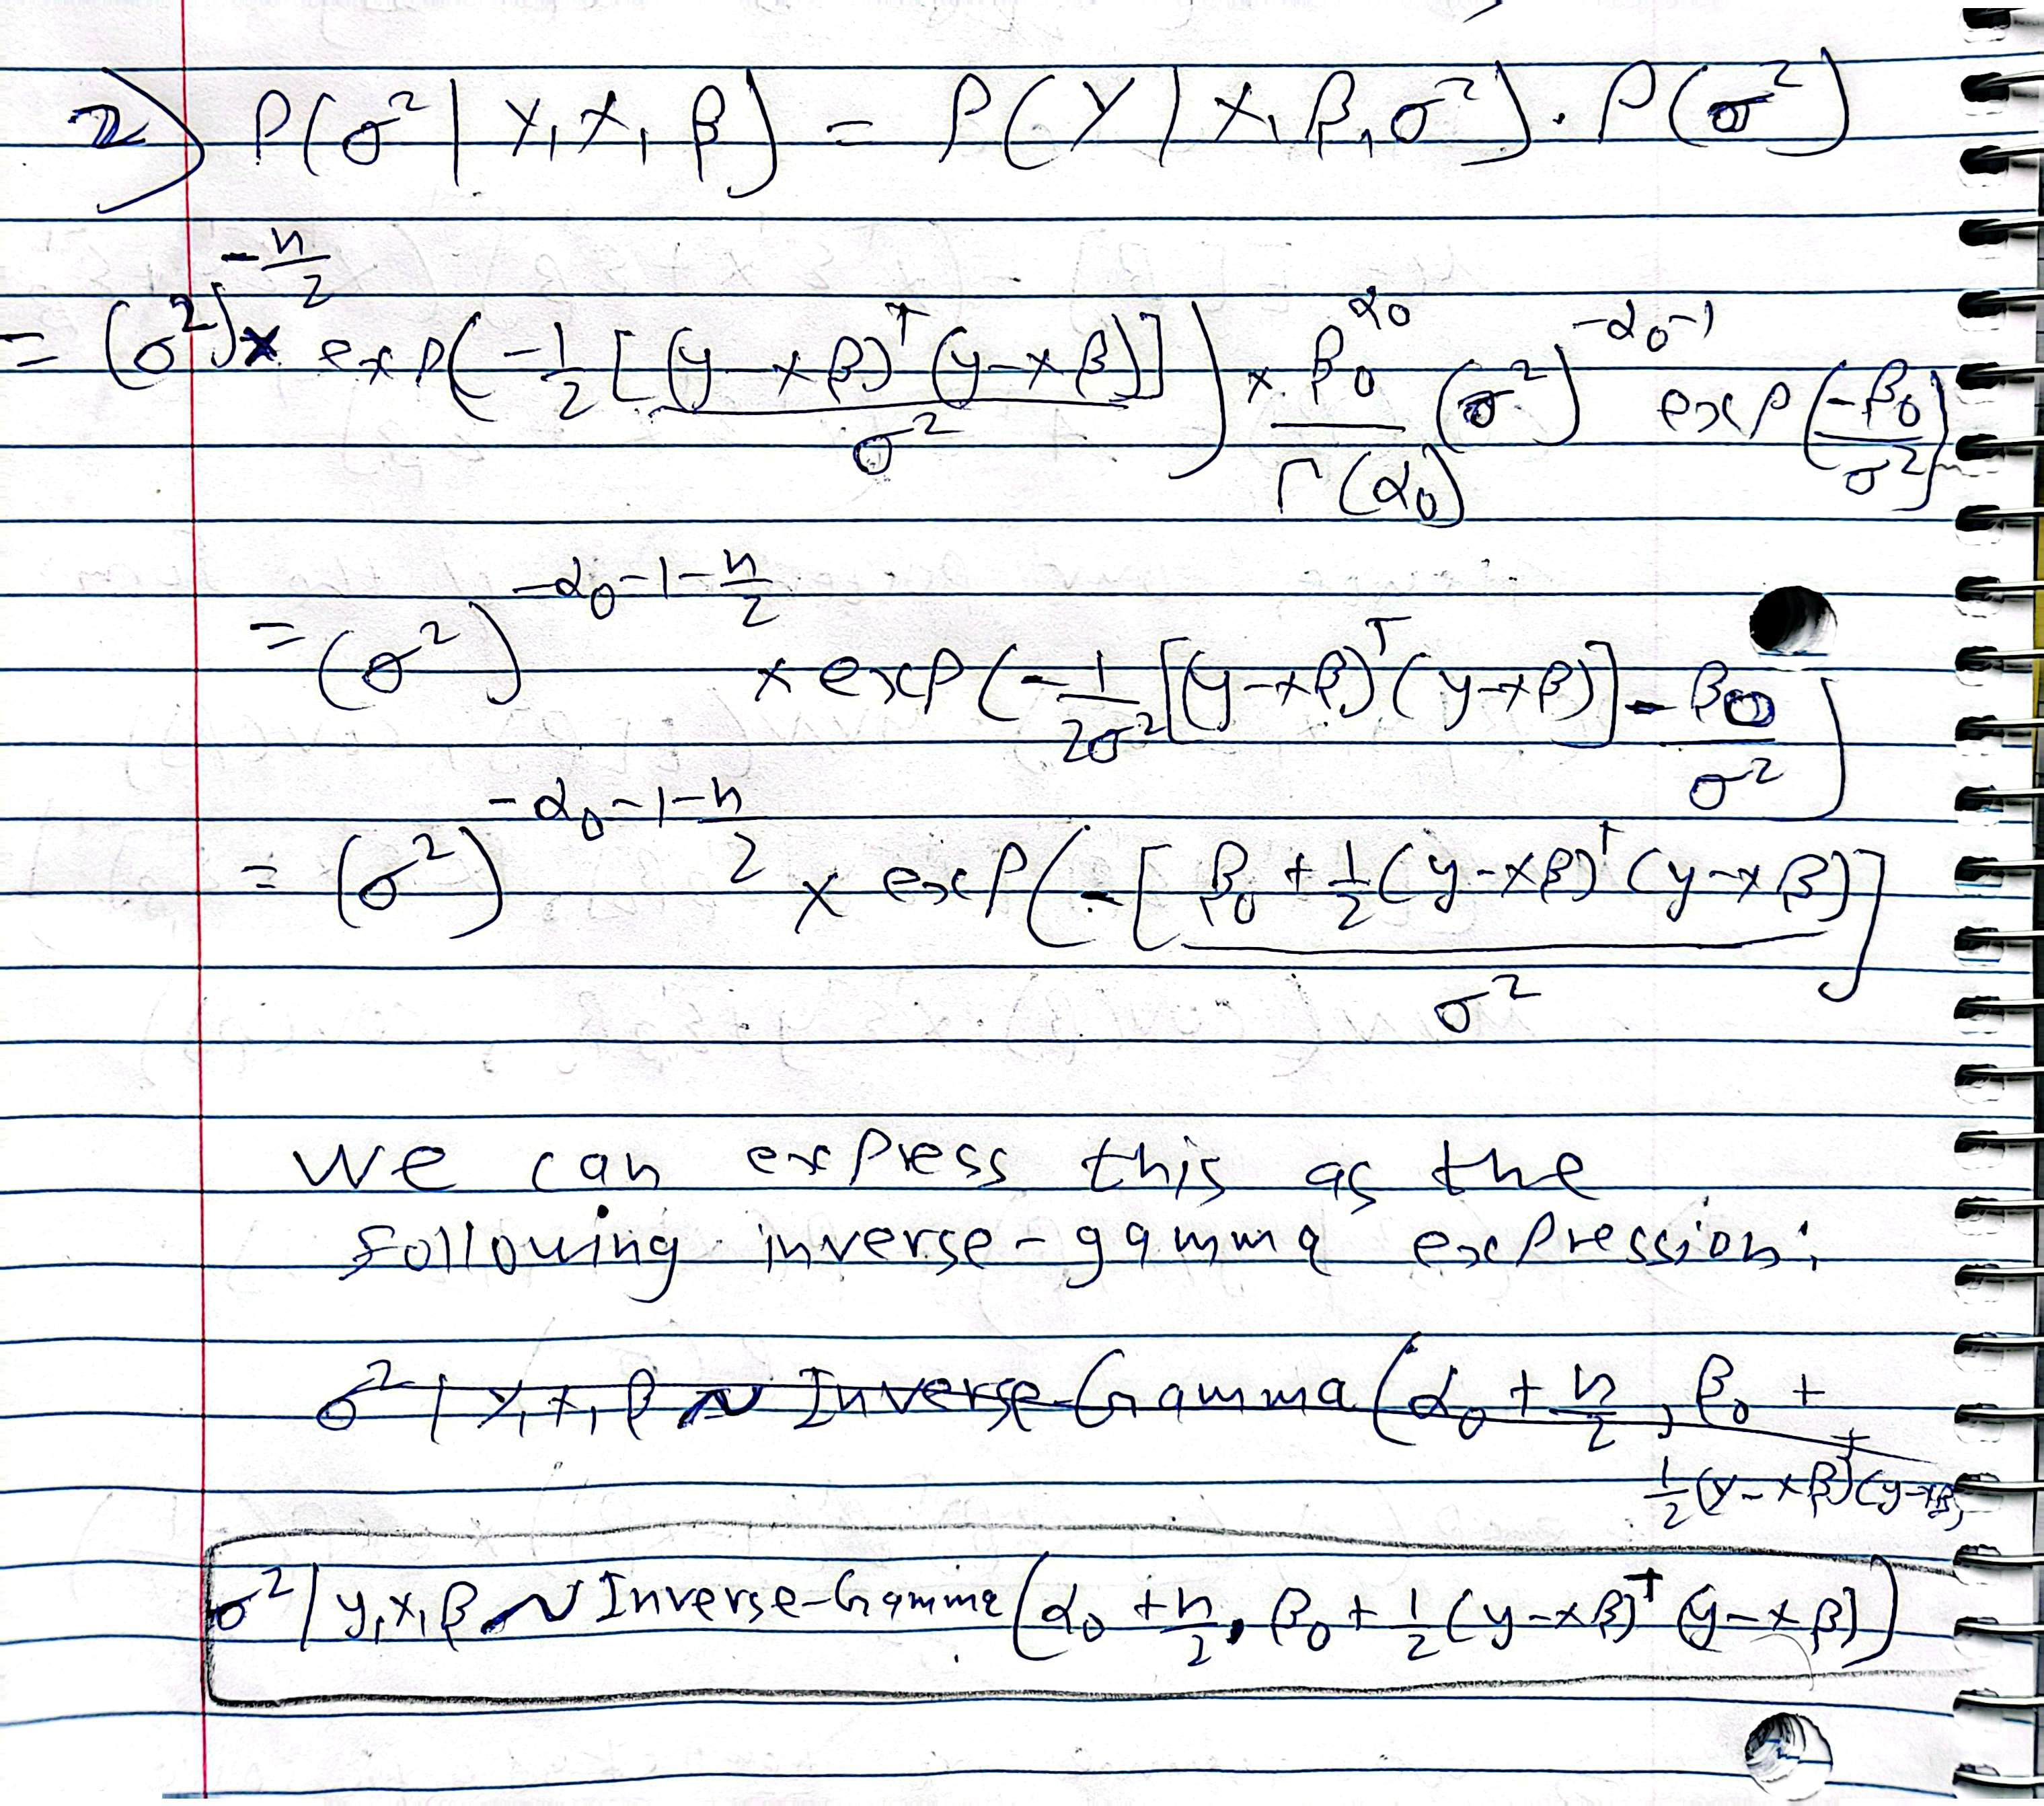

## Q2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train_energy_data.csv')

In [3]:
data.head()

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,Residential,7063,76,10,29.84,Weekday,2713.95
1,Commercial,44372,66,45,16.72,Weekday,5744.99
2,Industrial,19255,37,17,14.30,Weekend,4101.24
3,Residential,13265,14,41,32.82,Weekday,3009.14
4,Commercial,13375,26,18,11.92,Weekday,3279.17


In [4]:
data = data.dropna()

In [5]:
#adding a column of ones for the intercept
data['intercept'] = 1

In [6]:
data.head()

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption,intercept
0,Residential,7063,76,10,29.84,Weekday,2713.95,1
1,Commercial,44372,66,45,16.72,Weekday,5744.99,1
2,Industrial,19255,37,17,14.30,Weekend,4101.24,1
3,Residential,13265,14,41,32.82,Weekday,3009.14,1
4,Commercial,13375,26,18,11.92,Weekday,3279.17,1


We will be treating energy consumption as our response variable y and 'Appliances Used', 'Number of Occupants','Square footage', and 'Average Temperature' as our X matrix. 

For our sigma prior we use a Half-Cauchy prior which is weakly informative.

In [7]:
import pymc as pm

n,p=1000,5
X,y=data[['Appliances Used', 'Number of Occupants','Square Footage','Average Temperature','intercept']].values, data['Energy Consumption'].values

with pm.Model() as LR:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    sigma = pm.HalfCauchy('sigma', beta=1) 
    y = pm.Normal('y', mu=X@betas, sigma=sigma, observed=y)
    
    
with LR:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [8]:
import arviz as az

In [9]:
az.summary(idata,round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],13.88639,0.99496,12.07144,15.83161,0.01807,0.01278,3045.16508,2536.51356,0.99960
betas[1],15.95674,0.67604,14.74013,17.25783,0.01112,0.00787,3715.13178,2843.77874,1.00204
betas[2],0.09626,0.00180,0.09293,0.09963,0.00004,0.00003,2367.87786,2438.56006,0.99957
betas[3],9.43391,0.99001,7.60296,11.31276,0.01480,0.01052,4472.67803,3174.48290,1.00059
betas[4],0.46684,1.00086,-1.36908,2.46133,0.01440,0.01585,4829.81409,2833.27910,1.00227
sigma,894.88472,27.98422,841.38151,946.26124,0.53456,0.37849,2753.00334,2772.38296,0.99991


We can see the high density intervals of each beta along with sigma and make bayesian inference statements on all of them.

For example, for beta_1, there is a 94% probability that the value of beta_1 lies between 14.74 and 17.26

For our error standard deviation, there is a 94% probability it lies between 841.4 and 946.26

Based on our results, we can say first off that running 8000 samples was sufficient in getting convergence. The Monte carlo mean and standard deviation is a very small proportion of the actual mean and standard deviation of our betas and error variance. Moreover, we achieved convergence as suggested by the r_hat measure, seeing that all measures are below 1.01. Eventhough some measures have a r_hat of 0.9999, this is approximately 1 when we apply numerical rounding.

The only caveat here lies in the effective sample size bulk. Beta 4 has a reasonable effecive sample size of 4829 which is more than half of 8000. This implies that beta 4 has been able to shake of its dependence structure early and produce many independent samples. Even beta 3 is 4472 which is more than 50% of the iterations. Interestingly, the other betas are below 50% of the total iterations. This implies that they shake of their dependent structure later in the chain. This likely has to do with the beta prior being a normal distribution. One explanation for their lower ess_bulk could be that the predictors are correlated i.e there is some degree of multicollinearity. Thus, without a multivariate normal prior we cannot model the dependencies between predictors. This can likely explain why the ess_bulk is on the lower side for these betas. 

We also see that our sigma has a low ess_bulk of 2753. This may imply that our error terms are not randomly distributed. In other words, there are likely patterns within the data that are still not captured by the model. This means that either we must add more predictors or add a link function depending on the residual distribution. 

## Q3

In [10]:
# inserting synthetic outliers in the data
np.random.seed(42)
n_outliers = 5

#generating outlier indices
outlier_indices = np.random.choice(data.index, size=n_outliers, replace=False)

# Introducing outliers in our response variable using the outlier indices
data.loc[outlier_indices, 'Energy Consumption'] *= 5

X,y=data[['Appliances Used', 'Number of Occupants','Square Footage','Average Temperature','intercept']].values, data['Energy Consumption'].values




In [11]:
#building robust bayesian linear regression model
with pm.Model() as robust_bayesian_lr:
    # Priors for regression coefficients
    beta = pm.Normal('beta', mu=0, sigma=1, shape=p)
    
    # Global precision (inverse variance)
    tau = pm.Gamma('tau', alpha=1, beta=1)
    
    # prior for 'v' 
    nu = pm.Gamma('nu', alpha=2, beta=0.5)  # Prior for robustness
    
    # Individual precisions for each observation (tau_i)
    #using non-centered parametrization for better mixing
    tau_raw = pm.Gamma('tau_raw', alpha=2, beta=2, shape=n)
    tau_i = pm.Deterministic("tau_i", tau_raw * (nu / 2))

    
    # error standard deviation of regression, represented as a function of the global precision and individual precision 
    sigma_i = pm.Deterministic('sigma_i', 1 / pm.math.sqrt(tau * tau_i)) # Convert precision to std dev
    
    y_obs = pm.Normal('y_obs', mu=X@beta, sigma=sigma_i, observed=y)
    
    # Sample from posterior
with robust_bayesian_lr:
    idata_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, tau, nu, tau_raw]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


For the 'v' or nu parameter, I selected a gamma prior which is reasonably constrained in its specification. It helps avoid extreme tails and faciliates mixing better. 

Gamma distributions were also used for universal precision and individual precision. However, individual precision was defined using non-centered reparametrization. Basically we sample the raw tau independently and then scale it by v/2 to ensure we get the same distribution. This helps break any strong correlation/dependence structure. This was done because we got convergence issues and very low ess_bulk values without this.

sigma_i which is the standard deviation of the normal likelihood function of our response variable 'y'is a function of universal and individual precision. Our betas have a normal prior. T

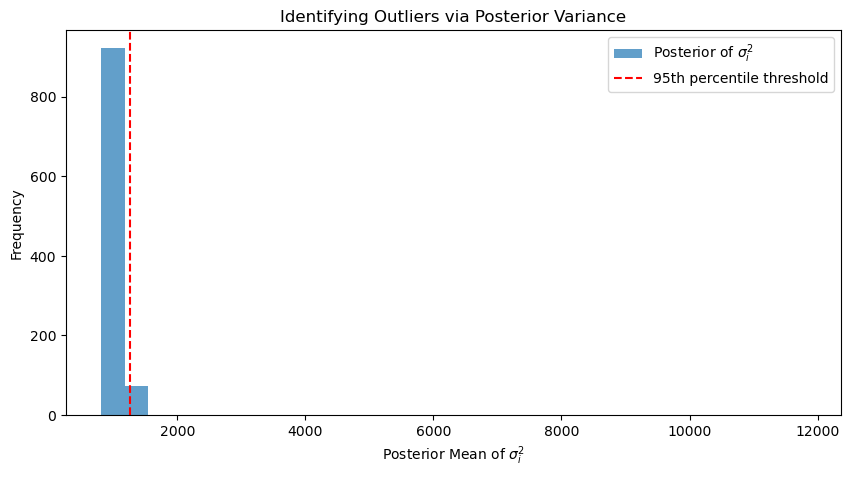

Identified Outlier Indices: [ 60  92  97 104 105 124 142 176 186 250 257 267 269 275 286 294 316 328
 386 405 411 412 458 464 483 490 495 520 521 524 530 564 574 659 660 667
 693 717 737 740 807 844 853 863 864 872 913 923 953 996]


In [12]:
# Extract posterior means of sigma_i^2
sigma_i_post = idata_2.posterior['sigma_i'].mean(dim=["chain", "draw"])

# Identify high-variance observations as outliers
threshold = np.percentile(sigma_i_post, 95)  # Top 5% highest variances
outlier_indices = np.where(sigma_i_post > threshold)[0]

# Plot sigma_i distribution
plt.figure(figsize=(10, 5))
plt.hist(sigma_i_post, bins=30, alpha=0.7, label="Posterior of $\sigma_i^2$")
plt.axvline(threshold, color="red", linestyle="dashed", label="95th percentile threshold")
plt.legend()
plt.xlabel("Posterior Mean of $\sigma_i^2$")
plt.ylabel("Frequency")
plt.title("Identifying Outliers via Posterior Variance")
plt.show()

print(f"Identified Outlier Indices: {outlier_indices}")

As we can see, when we plot the means of our posterior distribution of sigma_i, the points with the highest 5% variance are selected as outliers. Based on this criterion, our outliers are mentioned above.

The posterior mean is a good way to detect outliers because it gives a stable and interpretable summary of the expected noise for each observation. If we just took the posterior distribution we would be analyzing all posteriors of sigma conditional on X which is impractical. Insetad, we take the posterior mean of sigma conditional on each X and then use that to detect outliers. 



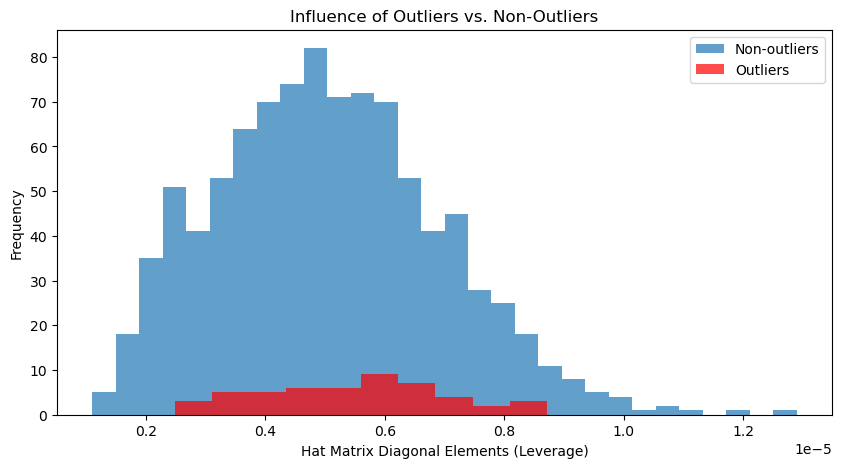

In [13]:
# Compute Hat matrix diagonals: X.T (X.T D X)^-1 X
X_t_X_inv = np.linalg.inv(X.T @ np.diag(sigma_i_post) @ X)
H_diag = np.diag(X @ X_t_X_inv @ X.T)

# Compare outliers vs non-outliers
outliers = H_diag[outlier_indices]
non_outliers = H_diag[np.setdiff1d(np.arange(n), outlier_indices)]

plt.figure(figsize=(10, 5))
plt.hist(non_outliers, bins=30, alpha=0.7, label="Non-outliers")
plt.hist(outliers, bins=10, alpha=0.7, label="Outliers", color="red")
plt.xlabel("Hat Matrix Diagonal Elements (Leverage)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Influence of Outliers vs. Non-Outliers")
plt.show()

By computing the Hat matrix manually using our data, we plotted a histogram of the diagonal of the hat matrix which gives us the 
leverage of each point. This plot shows us the leverage distribution with outliers and non-outliers highlighted. We can see that the non-outliers have far greater leverage on average relative to the outliers. This suggests that our outliers do not actually make a big difference to the bayesian regression model suggesting that we may have a robust model.

In [14]:
az.summary(idata_2, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],13.51442,0.97223,11.55775,15.23873,0.01272,0.00903,5823.69269,3248.27031,1.00051
beta[1],16.27482,0.66740,15.01810,17.48653,0.01020,0.00722,4292.05580,3326.82654,1.00048
beta[2],0.09555,0.00169,0.09238,0.09879,0.00003,0.00002,3690.68354,2989.96246,1.00042
beta[3],9.38305,1.01186,7.40484,11.19050,0.01274,0.00902,6309.51757,3122.03501,1.00032
beta[4],0.46342,0.98006,-1.35991,2.30097,0.01008,0.01530,9430.97486,3016.84019,1.00123
...,...,...,...,...,...,...,...,...,...
tau_raw[995],1.20037,0.73742,0.06050,2.50732,0.00953,0.00792,5292.75757,2207.17379,1.00089
tau_raw[996],0.51995,0.32301,0.02666,1.09844,0.00369,0.00324,6635.75852,2580.10915,1.00061
tau_raw[997],1.07026,0.67818,0.05658,2.27021,0.00706,0.00713,8404.40181,1765.21240,1.00033
tau_raw[998],1.03244,0.64580,0.05984,2.16969,0.00741,0.00681,6200.40342,2324.76579,1.00074


As per the pymc MCMC convegrence, there were no serious issues related to convergence or ess_bulk. Although some parameters have ess_bulk that is lower than 50% of all iterations, their r_hats are below 1.01. 